# K-Nearest Neighbors (KNN)

## Libraries Loading

In [17]:
library(tidyverse)
library(ggplot2)
library(caret)
library(caTools)
library(class)

## Data loading

In [18]:
data <- read_csv('../00_data/Social_Network_Ads.csv')
head(data)

Rows: 400 Columns: 3
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): Age, EstimatedSalary, Purchased

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,EstimatedSalary,Purchased
<dbl>,<dbl>,<dbl>
19,19000,0
35,20000,0
26,43000,0
27,57000,0
19,76000,0
27,58000,0


In [3]:
# data structure
glimpse(data)

Rows: 400
Columns: 3
$ Age             <dbl> 19, 35, 26, 27, 19, 27, 27, 32, 25, 35, 26, 26, 20, 32…
$ EstimatedSalary <dbl> 19000, 20000, 43000, 57000, 76000, 58000, 84000, 15000…
$ Purchased       <dbl> 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, …


In [4]:
data <- data |>
        mutate(Purchased = factor(data$Purchased, levels = c(0, 1), labels = c('No', 'Yes')))

In [5]:
glimpse(data)

Rows: 400
Columns: 3
$ Age             <dbl> 19, 35, 26, 27, 19, 27, 27, 32, 25, 35, 26, 26, 20, 32…
$ EstimatedSalary <dbl> 19000, 20000, 43000, 57000, 76000, 58000, 84000, 15000…
$ Purchased       <fct> No, No, No, No, No, No, No, Yes, No, No, No, No, No, N…


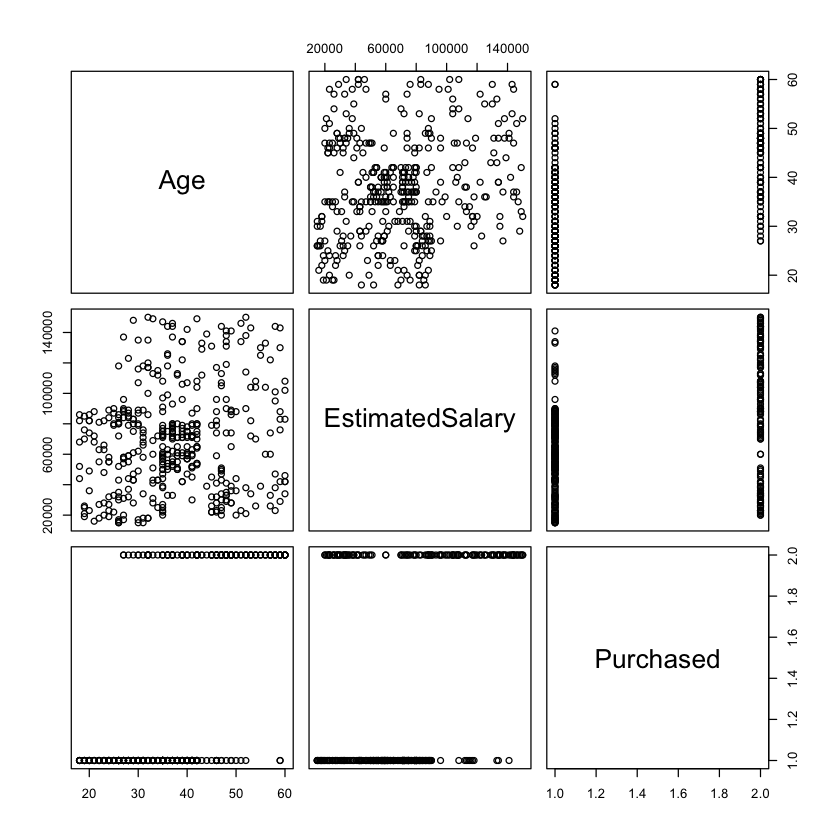

In [6]:
pairs(data)

# Splitting data into training and test set

In [7]:
set.seed(123)

train_data <- data |> slice_sample(prop = 0.75)
test_data <- data |> anti_join(train_data)

Joining with `by = join_by(Age, EstimatedSalary, Purchased)`


## Feature scaling

In [8]:
train_data[-3] <- scale(train_data[, -3])
test_data[-3] <- scale(test_data[, -3])

## Fit the model on training set and predict on test set

In [9]:
y_pred <- knn(train = train_data[, -3],
           test = test_data[, -3],
           cl = train_data$Purchased, # classes from training set
           k = 5)
y_pred

[1] No  No  Yes No  Yes Yes Yes Yes No  No  No  Yes No  No  Yes No  Yes No  No 
[20] No  No  No  No  No  No  Yes No  No  No  No  No  No  No  No  No  Yes No  No 
[39] No  No  No  Yes No  No  No  No  No  No  No  No  No  Yes Yes Yes Yes No  Yes
[58] Yes Yes Yes No  No  Yes Yes No  Yes No  Yes Yes No  No  No  Yes No  Yes No 
[77] Yes Yes Yes Yes Yes Yes Yes Yes
Levels: No Yes

## Evaluation the model

### Confusion Matrix

In [10]:
cm <- table(test_data$Purchased, y_pred)
cm

     y_pred
      No Yes
  No  47   6
  Yes  3  28

**Interpretation:**
$$
\begin{bmatrix}
True Negative & False Positive\\
False Negative & True Positive
\end{bmatrix}
$$

### Accuracy Score

In [11]:
accuracy <- mean(test_data$Purchased == y_pred)
print(paste0('Accuracy :', round(accuracy*100, 2), "%"))

[1] "Accuracy :89.29%"


## Viz the results

In [12]:
knn_pred_boundary <- function(df_train, df_test, name){
    X1 <- seq(min(df_test$Age) - 1, max(df_test$Age) + 1, length.out = 200)
    X2 <- seq(min(df_test$EstimatedSalary) - 1, max(df_test$EstimatedSalary) + 1, length.out = 200)
    grid <- expand.grid(X1, X2)
    colnames(grid) <- c('Age', 'EstimatedSalary')
    grid$Prediction <- knn(train = df_train[, -3],
                           test = grid,
                           cl = df_train$Purchased,
                           k = 5)
    print(ggplot() +
        geom_tile(data=grid, aes(x = Age, y = EstimatedSalary, fill = as.factor(Prediction)), alpha=0.4) +
        geom_point(df_test, mapping=aes(x = Age, y = EstimatedSalary, colour = Purchased), size=2) +
        scale_fill_manual(values = c("red", "blue"), name = "Prediction") +
        scale_color_manual(values = c("red", "blue"), name = "Purchased") +
        labs(title = paste0("KNN (", name,")"), x = "Age", y = "Estimated Salary") +
        theme_minimal())
}

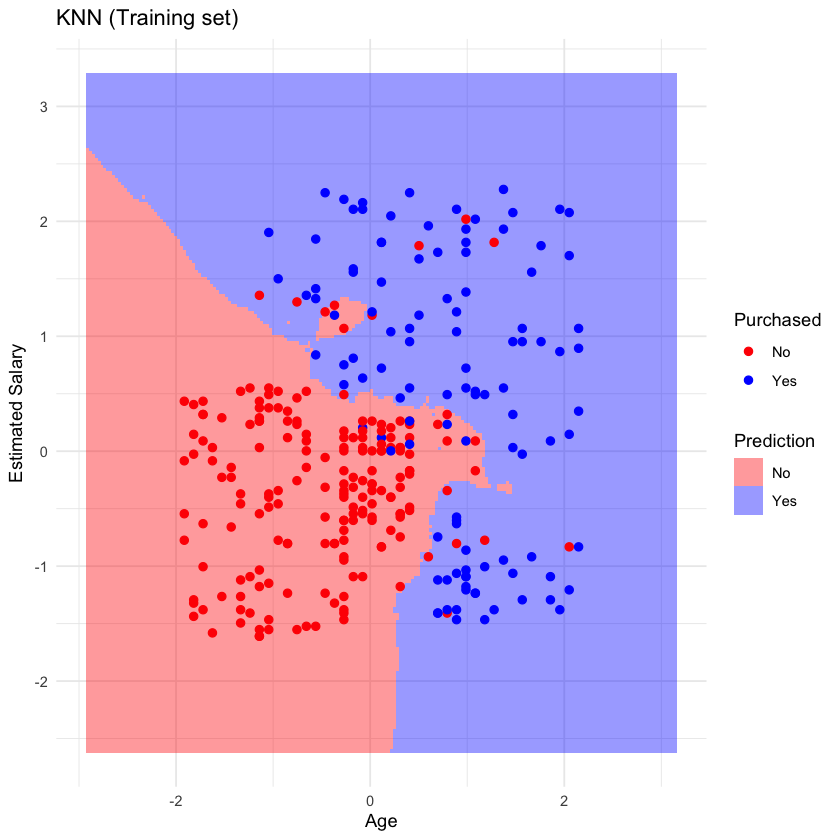

In [13]:
knn_pred_boundary(train_data, train_data, 'Training set')

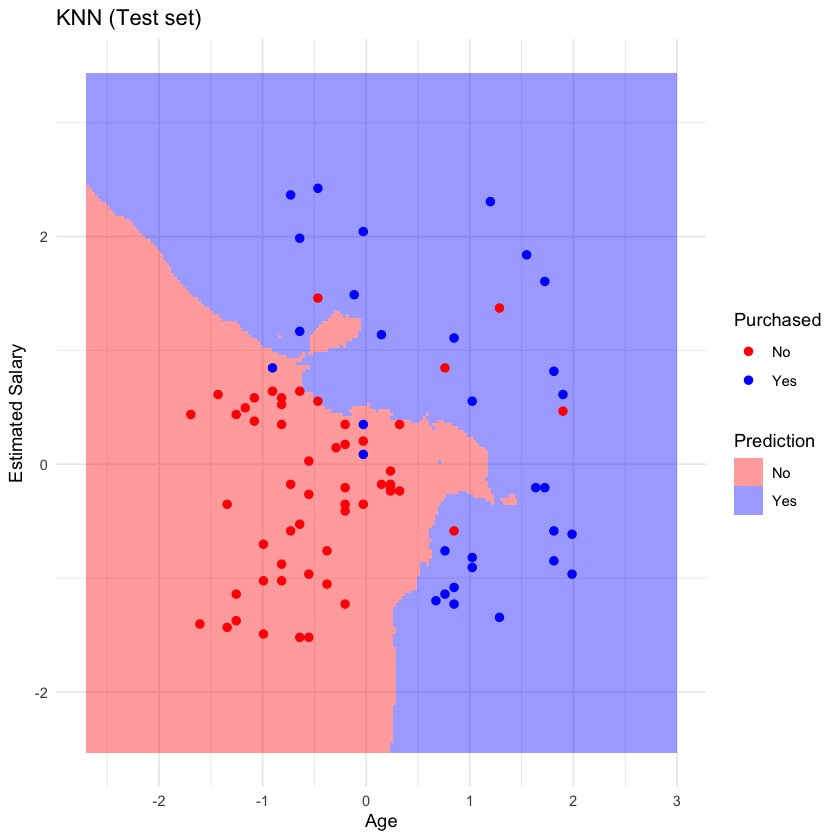

In [14]:
knn_pred_boundary(train_data, test_data, 'Test set')

## Cross Validation

[1] "Best tune: k=14"


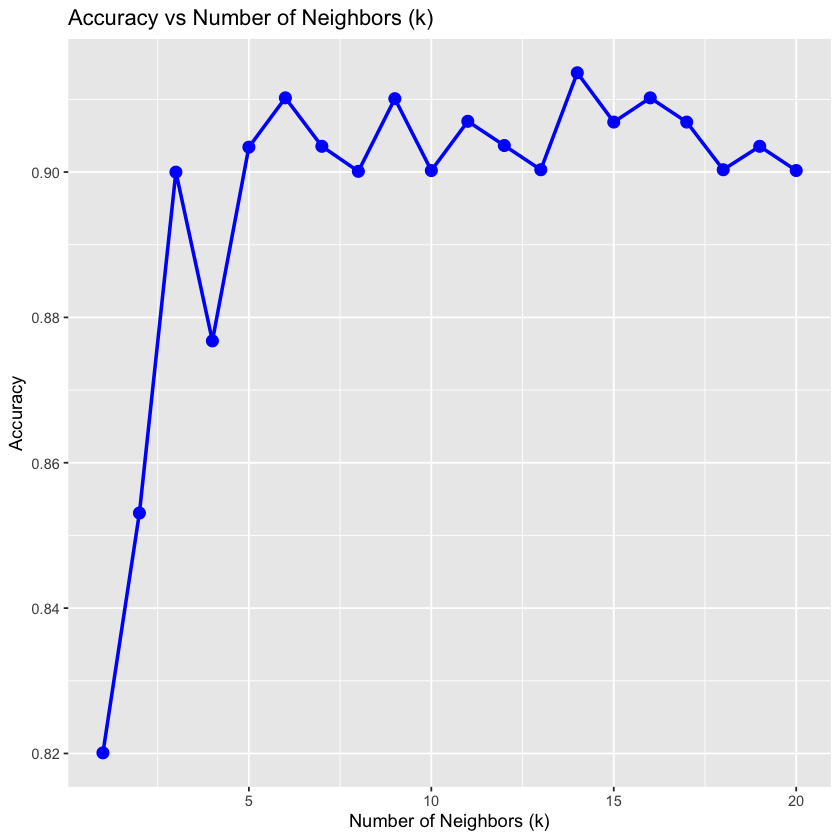

In [15]:
control <- trainControl(method = 'cv', number = 10)

set.seed(444)
cv_model <- train(Purchased ~ ., 
                  data = train_data, 
                  method = 'knn', 
                  tuneGrid = expand.grid(k = 1:20),
                  trControl = control, 
                  preProcess = c("center", "scale"))


print(paste0('Best tune: k=', cv_model$bestTune))

cv_model$results |>
ggplot(aes(x = k, y = Accuracy)) +
    geom_line(color = 'blue', linewidth = 1) +
    geom_point(color = 'blue', size = 3) +
    labs(title = 'Accuracy vs Number of Neighbors (k)', x = 'Number of Neighbors (k)', y = 'Accuracy')


In [16]:
pred_prob <- predict(cv_model$finalModel, newdata=test_data[, -3], )
y_pred <- colnames(pred_prob)[apply(pred_prob, 1, which.max)]

accuracy <- mean(test_data$Purchased == y_pred)
print(paste0('Accuracy on test set (best model): ', round(accuracy*100, 2), "%"))

[1] "Accuracy on test set (best model): 91.67%"
